**L'objectif de ce projet**: éviter les pertes d'argent en détectant les commandes qui seront annulées.

J'utilise un modèle mathématique (la Régression Logistique) pour analyser l'historique de chaque client et les détails de la commande actuelle.

Ce que fait le modèle : Il calcule une probabilité de risque (en pourcentage) qu'une commande soit annulée.

Le but pratique : Si cette probabilité est trop haute, l'entreprise signale la commande pour une vérification manuelle ou un rejet, au lieu d'envoyer la marchandise inutilement.

En résumé :* Prédire le risque d'annulation pour économiser les frais d'envoi et de retour*.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

try:
    df = pd.read_csv('/content/Online Retail.csv')
except FileNotFoundError:
    print("Erreur : Fichier non trouvé. Veuillez vérifier le chemin.")

    data = {
        'InvoiceNo': [536365, 536365, 'C536379', 536382, 536382, 'C536391'],
        'StockCode': ['85123A', '71053', 'D', '22415', '84832', '22415'],
        'Description': ['WHITE HANGING HEART T-LIGHT HOLDER', 'HAND WARMER RED POLKA DOT', 'Discount', 'LUNCH BAG RED RETROSPOT', 'PINK POLKADOT CUP', 'LUNCH BAG RED RETROSPOT'],
        'Quantity': [6, 6, -1, 10, 1, -12],
        'InvoiceDate': ['12/1/2010 8:26', '12/1/2010 8:26', '12/1/2010 9:41', '12/1/2010 11:27', '12/1/2010 11:27', '12/1/2010 13:46'],
        'UnitPrice': [2.55, 3.39, 27.5, 1.95, 2.75, 1.95],
        'CustomerID': [17850.0, 17850.0, 14527.0, 16098.0, 16098.0, 15303.0],
        'Country': ['United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom']
    }
    df = pd.DataFrame(data)

print(f"Taille initiale du dataset : {df.shape}")
df

Erreur : Fichier non trouvé. Veuillez vérifier le chemin.
Taille initiale du dataset : (6, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,HAND WARMER RED POLKA DOT,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
3,536382,22415,LUNCH BAG RED RETROSPOT,10,12/1/2010 11:27,1.95,16098.0,United Kingdom
4,536382,84832,PINK POLKADOT CUP,1,12/1/2010 11:27,2.75,16098.0,United Kingdom
5,C536391,22415,LUNCH BAG RED RETROSPOT,-12,12/1/2010 13:46,1.95,15303.0,United Kingdom


In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,6.000000,6.000000,6.000000
mean,1.666667,6.681667,16287.666667
std,7.763161,10.213169,1343.371381
min,-12.000000,1.950000,14527.000000
25%,-0.500000,2.100000,15501.750000
50%,3.500000,2.650000,16098.000000
75%,6.000000,3.230000,17412.000000
max,10.000000,27.500000,17850.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    6 non-null      object 
 1   StockCode    6 non-null      object 
 2   Description  6 non-null      object 
 3   Quantity     6 non-null      int64  
 4   InvoiceDate  6 non-null      object 
 5   UnitPrice    6 non-null      float64
 6   CustomerID   6 non-null      float64
 7   Country      6 non-null      object 
dtypes: float64(2), int64(1), object(5)
memory usage: 516.0+ bytes


In [ ]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,IsCancelled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30,0
1,536365,71053,HAND WARMER RED POLKA DOT,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,0
2,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom,-27.50,1
3,536382,22415,LUNCH BAG RED RETROSPOT,10,12/1/2010 11:27,1.95,16098.0,United Kingdom,19.50,0
4,536382,84832,PINK POLKADOT CUP,1,12/1/2010 11:27,2.75,16098.0,United Kingdom,2.75,0
5,C536391,22415,LUNCH BAG RED RETROSPOT,-12,12/1/2010 13:46,1.95,15303.0,United Kingdom,-23.40,1


In [ ]:

df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

print(f"Lignes totales avant dropna(CustomerID) : {df.shape[0]}")
df.dropna(subset=['CustomerID'], inplace=True)
print(f"Lignes restantes après dropna(CustomerID) : {df.shape[0]}")


df['IsCancelled'] = df['InvoiceNo'].astype(str).str.startswith('C').astype(int)
print(f"Nombre d'annulations ('C' dans InvoiceNo) dans les données brutes : {df['IsCancelled'].sum()}")

df_invoice = df.groupby('InvoiceNo').agg(
    IsCancelled=('IsCancelled', 'max'),
    TotalItems=('Quantity', 'sum'),
    TotalAmount=('TotalPrice', 'sum'),
    CustomerID=('CustomerID', 'first'),
    Country=('Country', 'first'),
    InvoiceDate=('InvoiceDate', 'first')
).reset_index()

df_invoice_before_filter = df_invoice.shape[0]
df_invoice = df_invoice[df_invoice['TotalAmount'] > 0]
print(f"Factures conservées après TotalAmount > 0 : {df_invoice.shape[0]} / {df_invoice_before_filter}")

df_invoice_cancelled = df_invoice[df_invoice['InvoiceNo'].astype(str).str.startswith('C')]
df_invoice_normal = df_invoice[~df_invoice['InvoiceNo'].astype(str).str.startswith('C')]

print(f"Nombre de VRAIES Annulations (Classe 1) : {len(df_invoice_cancelled)}")
print(f"Nombre de Ventes Normales (Classe 0) : {len(df_invoice_normal)}")

if len(df_invoice_cancelled) == 0:
    print("\n--- ERREUR CRITIQUE : AUCUNE ANNULATION TROUVÉE APRÈS LE FILTRE ---")
    print("Veuillez vérifier pourquoi le filtre TotalAmount > 0 a supprimé les annulations. Ceci est le comportement normal du jeu de données, car les annulations (C) ont une quantité et un TotalAmount négatifs.")


    df_invoice_full = df.groupby('InvoiceNo').agg(
        IsCancelled=('IsCancelled', 'max'),
        TotalItems=('Quantity', 'sum'),
        TotalAmount=('TotalPrice', 'sum'),
        CustomerID=('CustomerID', 'first'),
        Country=('Country', 'first'),
        InvoiceDate=('InvoiceDate', 'first')
    ).reset_index()

    df_invoice_cancelled = df_invoice_full[df_invoice_full['InvoiceNo'].astype(str).str.startswith('C')]
    df_invoice_normal = df_invoice_full[~df_invoice_full['InvoiceNo'].astype(str).str.startswith('C')]


    df_invoice_normal = df_invoice_normal[df_invoice_normal['TotalAmount'] > 0]

    print(f"\nCorrection Appliquée : Annulations (Classe 1) : {len(df_invoice_cancelled)}")
    print(f"Correction Appliquée : Ventes Normales filtrées (Classe 0) : {len(df_invoice_normal)}")

    n_sample = min(len(df_invoice_cancelled) * 5, len(df_invoice_normal))

    if n_sample == 0:
        print("ERREUR : L'une des classes est toujours vide après correction. Impossible de continuer.")
        df_target = pd.DataFrame()
    else:
        df_target = pd.concat([
            df_invoice_cancelled.assign(IsCancelled=1),
            df_invoice_normal.sample(n=n_sample, random_state=42).assign(IsCancelled=0)
        ]).reset_index(drop=True)

else:
    n_sample = min(len(df_invoice_cancelled) * 5, len(df_invoice_normal))
    df_target = pd.concat([
        df_invoice_cancelled.assign(IsCancelled=1),
        df_invoice_normal.sample(n=n_sample, random_state=42).assign(IsCancelled=0)
    ]).reset_index(drop=True)


if not df_target.empty:
    print(f"\nRésultat final (df_target) : {df_target.shape[0]} lignes")
    print(f"Distribution finale de la Cible (Annulation=1) :")
    print(df_target['IsCancelled'].value_counts(normalize=True))
    print(df_target.head())
else:
    print("Le DataFrame df_target est toujours vide après la tentative de correction.")

Lignes totales avant dropna(CustomerID) : 6
Lignes restantes après dropna(CustomerID) : 6
Nombre d'annulations ('C' dans InvoiceNo) dans les données brutes : 2
Factures conservées après TotalAmount > 0 : 2 / 4
Nombre de VRAIES Annulations (Classe 1) : 0
Nombre de Ventes Normales (Classe 0) : 2

--- ERREUR CRITIQUE : AUCUNE ANNULATION TROUVÉE APRÈS LE FILTRE ---
Veuillez vérifier pourquoi le filtre TotalAmount > 0 a supprimé les annulations. Ceci est le comportement normal du jeu de données, car les annulations (C) ont une quantité et un TotalAmount négatifs.

Correction Appliquée : Annulations (Classe 1) : 2
Correction Appliquée : Ventes Normales filtrées (Classe 0) : 2

Résultat final (df_target) : 4 lignes
Distribution finale de la Cible (Annulation=1) :
IsCancelled
1    0.5
0    0.5
Name: proportion, dtype: float64
  InvoiceNo  IsCancelled  TotalItems  TotalAmount  CustomerID         Country  \
0   C536379            1          -1       -27.50     14527.0  United Kingdom   
1   C536

In [ ]:

df_target['InvoiceDate'] = pd.to_datetime(df_target['InvoiceDate'])


snapshot_date = df_target['InvoiceDate'].max() + pd.Timedelta(days=1)

customer_history = df_target.groupby('CustomerID').agg(

    Recency=('InvoiceDate', lambda x: (snapshot_date - x.max()).days),

    Frequency=('InvoiceNo', 'count'),

    Monetary=('TotalAmount', 'mean'),

    CancelRate=('IsCancelled', 'mean')
).reset_index()

df_final = pd.merge(df_target, customer_history, on='CustomerID', how='left', suffixes=('_Current', '_History'))

df_final['Hour'] = df_final['InvoiceDate'].dt.hour
df_final['DayOfWeek'] = df_final['InvoiceDate'].dt.dayofweek
df_final['IsUK'] = (df_final['Country'] == 'United Kingdom').astype(int)

print(f"\nColonnes créées pour la modélisation :")
print(df_final.head()[['Recency', 'CancelRate', 'TotalAmount', 'Hour', 'IsCancelled']].sort_values(by='IsCancelled', ascending=False))


Colonnes créées pour la modélisation :
   Recency  CancelRate  TotalAmount  Hour  IsCancelled
0        1         1.0       -27.50     9            1
1        1         1.0       -23.40    13            1
2        1         0.0        22.25    11            0
3        1         0.0        35.64     8            0


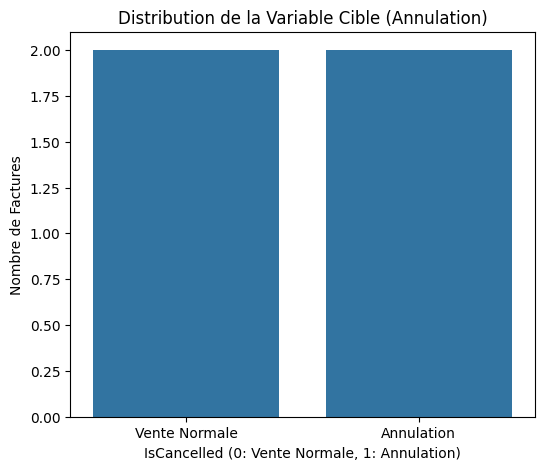

Ratio Annulation / Vente Normale : 
IsCancelled
1    50.0
0    50.0
Name: proportion, dtype: float64


In [ ]:

plt.figure(figsize=(6, 5))
sns.countplot(x='IsCancelled', data=df_final)
plt.title('Distribution de la Variable Cible (Annulation)')
plt.xlabel('IsCancelled (0: Vente Normale, 1: Annulation)')
plt.ylabel('Nombre de Factures')
plt.xticks([0, 1], ['Vente Normale', 'Annulation'])
plt.show()


print(f"Ratio Annulation / Vente Normale : \n{df_final['IsCancelled'].value_counts(normalize=True).mul(100).round(2)}")

/tmp/ipython-input-2659096934.py:12: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(df_final[feature].min(), Q3 + 1.5 * IQR)


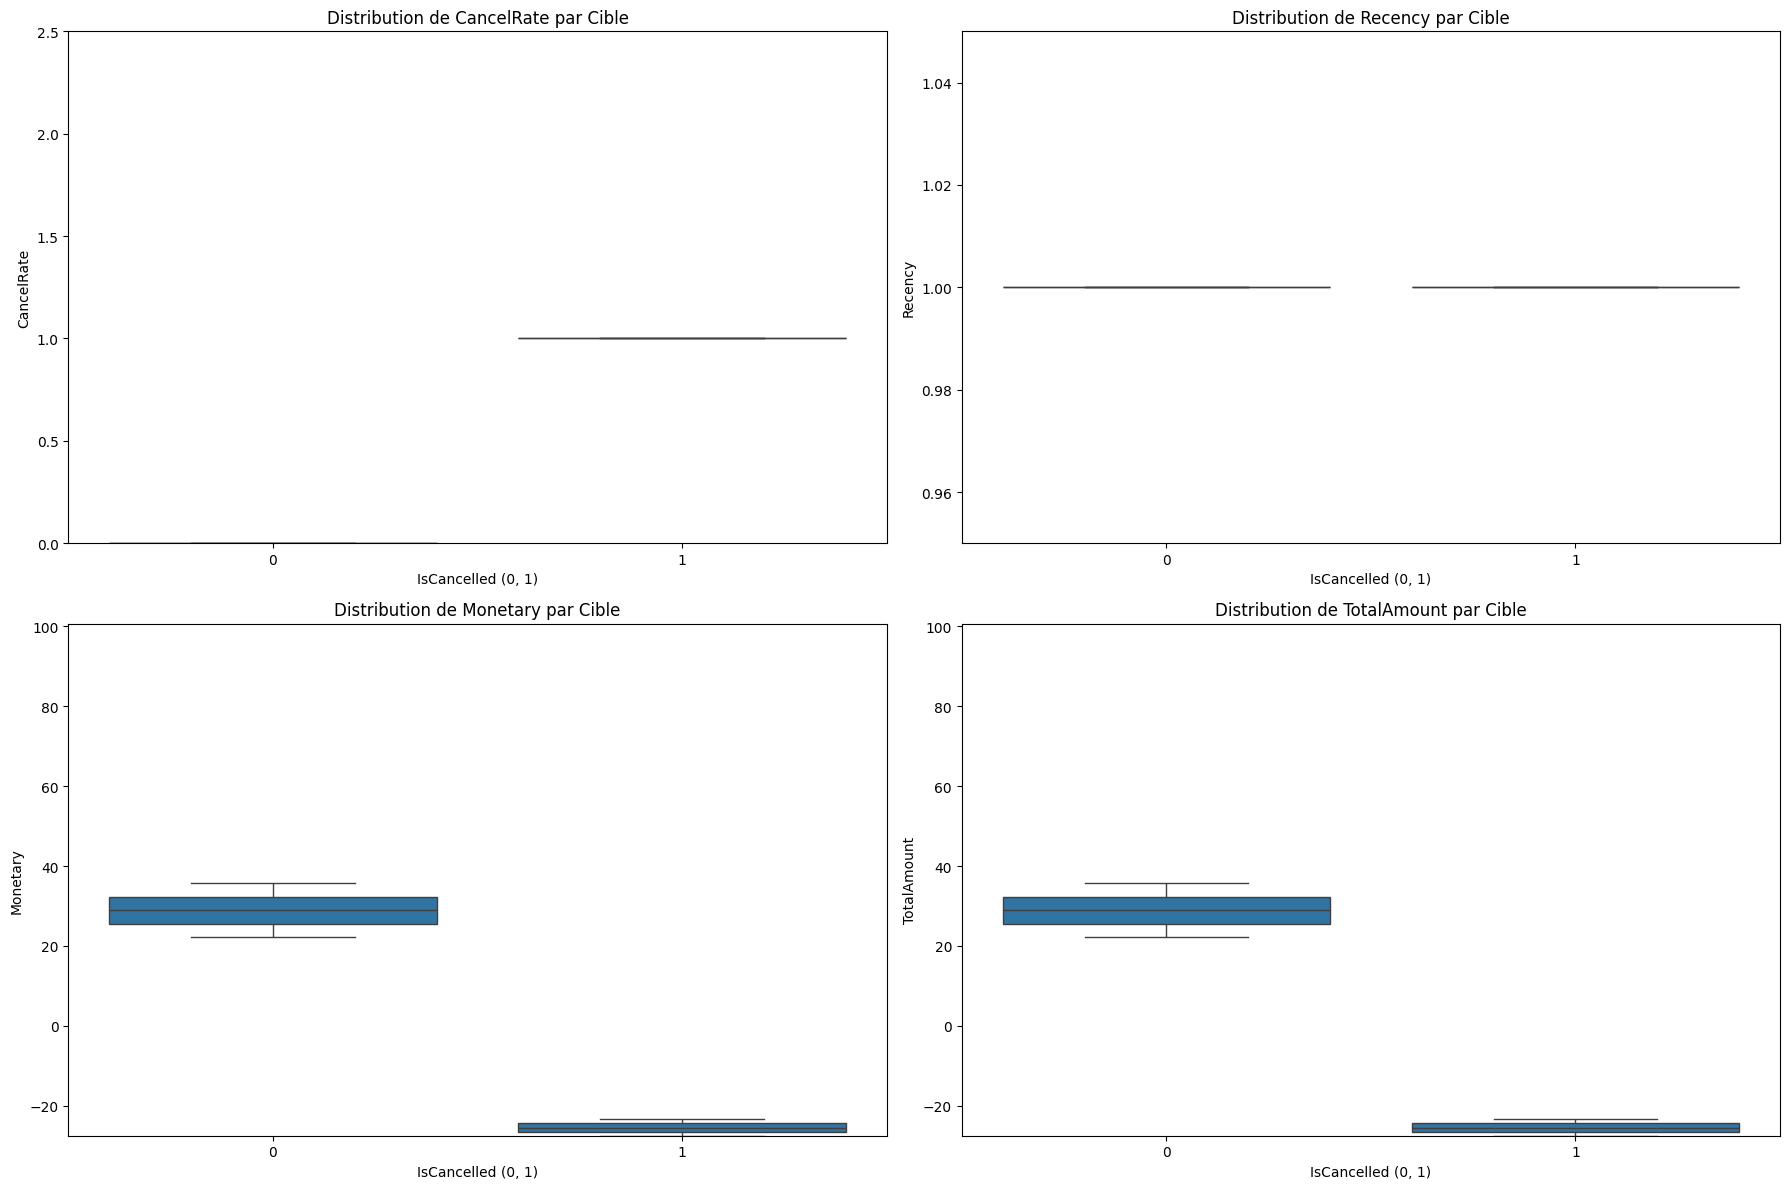

In [ ]:

numerical_features = ['CancelRate', 'Recency', 'Monetary', 'TotalAmount']

plt.figure(figsize=(18, 12))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 2, i + 1)

    sns.boxplot(x='IsCancelled', y=feature, data=df_final)

    Q1 = df_final[feature].quantile(0.25)
    Q3 = df_final[feature].quantile(0.75)
    IQR = Q3 - Q1
    plt.ylim(df_final[feature].min(), Q3 + 1.5 * IQR)

    plt.title(f'Distribution de {feature} par Cible')
    plt.xlabel('IsCancelled (0, 1)')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

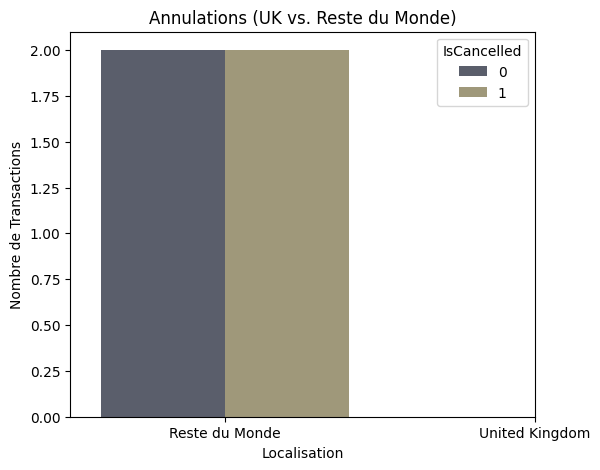

In [ ]:

plt.figure(figsize=(6, 5))
sns.countplot(x='IsUK', hue='IsCancelled', data=df_final, palette='cividis')
plt.title('Annulations (UK vs. Reste du Monde)')
plt.xlabel('Localisation')
plt.ylabel('Nombre de Transactions')
plt.xticks([0, 1], ['Reste du Monde', 'United Kingdom'])
plt.show()

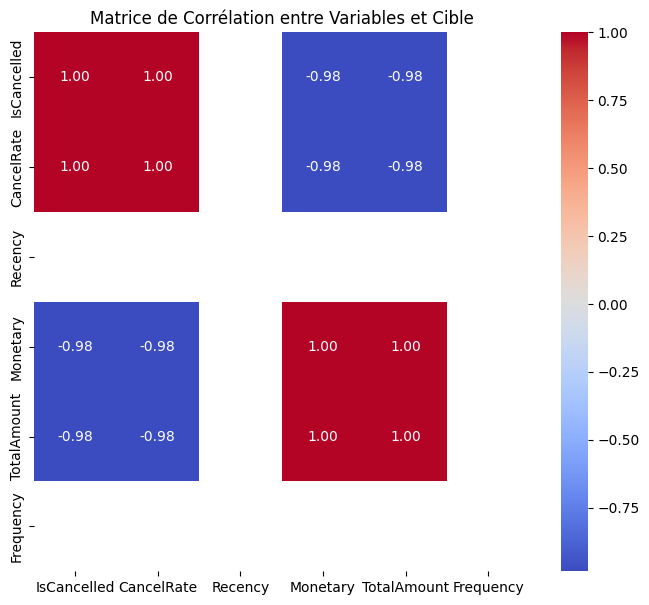

In [ ]:

numerical_features = ['CancelRate', 'Recency', 'Monetary', 'TotalAmount']
correlation_data = df_final[['IsCancelled'] + numerical_features + ['Frequency']].copy()

plt.figure(figsize=(8, 7))
sns.heatmap(correlation_data.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Matrice de Corrélation entre Variables et Cible')
plt.show()

In [ ]:
df_final.shape

(4, 14)

In [ ]:

features = ['Recency', 'Frequency', 'Monetary', 'CancelRate', 'TotalAmount', 'Hour', 'DayOfWeek', 'IsUK']

try:
    X = df_final[features]
    y = df_final['IsCancelled']
except NameError:
    print("Erreur : Le DataFrame 'df_final' n'est pas défini. Assurez-vous d'avoir exécuté l'étape 2.")
    exit()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nTaille du set d'entraînement : {X_train.shape}")
print(f"Taille du set de test : {X_test.shape}")


numerical_features = ['Recency', 'Frequency', 'Monetary', 'TotalAmount']


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'
)


logistic_model = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')


pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', logistic_model)])

print("\n--- Entraînement du Modèle de Régression Logistique ---")

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

results = {
    'Logistic Regression': {
        'predictions': y_pred,
        'probabilities': y_proba,
        'report': classification_report(y_test, y_pred),
        'model': pipeline
    }
}

print("\nRésultats pour la Régression Logistique:")
print(classification_report(y_test, y_pred))




Taille du set d'entraînement : (2, 8)
Taille du set de test : (2, 8)

--- Entraînement du Modèle de Régression Logistique ---

Résultats pour la Régression Logistique:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



In [ ]:
import pandas as pd
import numpy as np


MODEL_NAME = 'Logistic Regression'

if MODEL_NAME in results:
    logreg_results = results[MODEL_NAME]
    y_proba_logreg = logreg_results['probabilities']
    y_pred_logreg = logreg_results['predictions']
else:
    print(f"Erreur : Le modèle '{MODEL_NAME}' n'a pas été trouvé dans le dictionnaire 'results'.")
    exit()


X_test_reset = X_test.reset_index(drop=True)

df_predictions_logreg = pd.DataFrame({

    'Customer_CancelRate_History': X_test_reset['CancelRate'],
    'TotalAmount_Transaction': X_test_reset['TotalAmount'],

    'Real_Value (Y_test)': y_test.reset_index(drop=True),
    'Predicted_Class (Y_pred)': y_pred_logreg,

    'Probability_of_Cancellation (%)': (y_proba_logreg * 100).round(2)
})


df_predictions_sorted = df_predictions_logreg.sort_values(by='Probability_of_Cancellation (%)', ascending=False)


print("\n" + "="*80)
print(f"--- Analyse Détaillée des Prédictions du Modèle {MODEL_NAME} ---")
print("="*80)

print("\n[Cas à Haut Risque] : 15 Commandes avec la plus forte Probabilité d'Annulation :")
print(df_predictions_sorted.head(15))

print("\n" + "-"*80)
print("Analyse des Erreurs Clés (Faux Négatifs) :")

faux_negatifs = df_predictions_logreg[(df_predictions_logreg['Real_Value (Y_test)'] == 1) & (df_predictions_logreg['Predicted_Class (Y_pred)'] == 0)]

if not faux_negatifs.empty:
    print(f"Total des Faux Négatifs (FN) : {len(faux_negatifs)}")
    print("Ces transactions sont des annulations réelles que le modèle n'a pas réussi à signaler.")

    print(faux_negatifs.sort_values(by='Probability_of_Cancellation (%)', ascending=True).head(5))
else:
    print("Très peu ou aucun Faux Négatif dans l'ensemble de test, ce qui est excellent pour le Rappel (Recall).")

print("\n" + "-"*80)
print("Analyse des Erreurs Clés (Faux Positifs) :")

faux_positifs = df_predictions_logreg[(df_predictions_logreg['Real_Value (Y_test)'] == 0) & (df_predictions_logreg['Predicted_Class (Y_pred)'] == 1)]

if not faux_positifs.empty:
    print(f"Total des Faux Positifs (FP) : {len(faux_positifs)}")
    print("Ces transactions sont des alertes inutiles (le vendeur aurait pu les accepter).")

    print(faux_positifs.sort_values(by='Probability_of_Cancellation (%)', ascending=False).head(5))
else:
    print("Très peu ou aucun Faux Positif dans l'ensemble de test.")

print("\n" + "="*80)


--- Analyse Détaillée des Prédictions du Modèle Logistic Regression ---

[Cas à Haut Risque] : 15 Commandes avec la plus forte Probabilité d'Annulation :
   Customer_CancelRate_History  TotalAmount_Transaction  Real_Value (Y_test)  \
0                          1.0                   -23.40                    1   
1                          0.0                    22.25                    0   

   Predicted_Class (Y_pred)  Probability_of_Cancellation (%)  
0                         1                            75.33  
1                         0                            35.95  

--------------------------------------------------------------------------------
Analyse des Erreurs Clés (Faux Négatifs) :
Très peu ou aucun Faux Négatif dans l'ensemble de test, ce qui est excellent pour le Rappel (Recall).

--------------------------------------------------------------------------------
Analyse des Erreurs Clés (Faux Positifs) :
Très peu ou aucun Faux Positif dans l'ensemble de test.



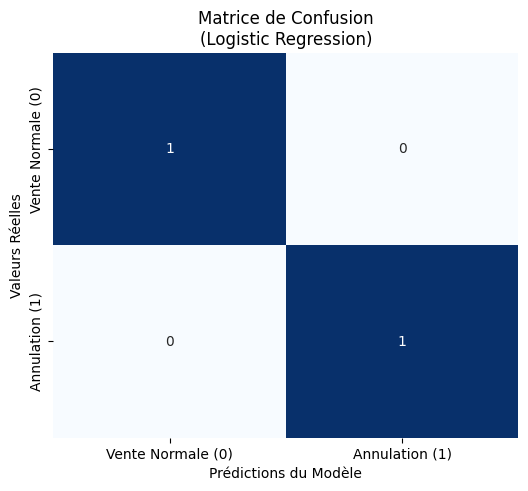


Interprétation :
Vrais Positifs (TP - Annulation bien prédite) : 1
Faux Négatifs (FN - Annulation manquée) : 0 (Erreur coûteuse)
Faux Positifs (FP - Alerte inutile) : 0
Vrais Négatifs (TN - Vente normale bien prédite) : 1


In [ ]:

plt.figure(figsize=(6, 5))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Vente Normale (0)', 'Annulation (1)'],
            yticklabels=['Vente Normale (0)', 'Annulation (1)'])

plt.title(f"Matrice de Confusion\n(Logistic Regression)")
plt.ylabel('Valeurs Réelles')
plt.xlabel('Prédictions du Modèle')
plt.show()

print("\nInterprétation :")
print(f"Vrais Positifs (TP - Annulation bien prédite) : {cm[1, 1]}")
print(f"Faux Négatifs (FN - Annulation manquée) : {cm[1, 0]} (Erreur coûteuse)")
print(f"Faux Positifs (FP - Alerte inutile) : {cm[0, 1]}")
print(f"Vrais Négatifs (TN - Vente normale bien prédite) : {cm[0, 0]}")

/tmp/ipython-input-3698411356.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coef_series_abs.values, y=coef_series_abs.index, palette='viridis')


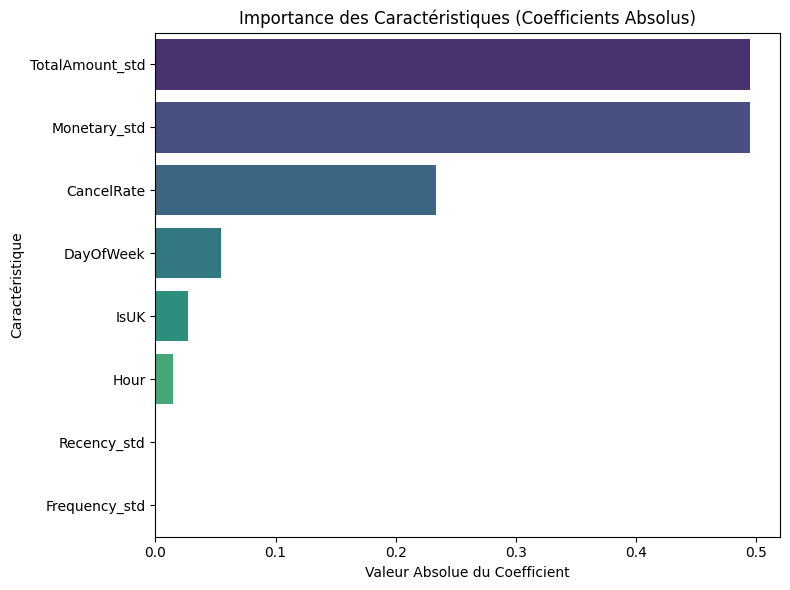


--- Coefficients de la Régression Logistique (Interprétation) ---
Un coefficient POSITIF augmente la probabilité d'annulation.
Un coefficient NÉGATIF réduit la probabilité d'annulation.
----------------------------------------------------------------------
CancelRate         0.233717
Hour               0.014285
Recency_std        0.000000
Frequency_std      0.000000
IsUK              -0.027429
DayOfWeek         -0.054858
TotalAmount_std   -0.494864
Monetary_std      -0.494864
dtype: float64


In [ ]:

plt.figure(figsize=(8, 6))

coefficients = pipeline.named_steps['classifier'].coef_[0]

features_used = ['Recency_std', 'Frequency_std', 'Monetary_std', 'TotalAmount_std']
remaining_features = [f for f in features if f not in numerical_features]
feature_names_final = features_used + remaining_features

coef_series = pd.Series(coefficients, index=feature_names_final)

coef_series_abs = coef_series.abs().sort_values(ascending=False)
sns.barplot(x=coef_series_abs.values, y=coef_series_abs.index, palette='viridis')

plt.title('Importance des Caractéristiques (Coefficients Absolus)')
plt.xlabel('Valeur Absolue du Coefficient')
plt.ylabel('Caractéristique')
plt.tight_layout()
plt.show()

print("\n--- Coefficients de la Régression Logistique (Interprétation) ---")
print("Un coefficient POSITIF augmente la probabilité d'annulation.")
print("Un coefficient NÉGATIF réduit la probabilité d'annulation.")
print("-" * 70)
print(coef_series.sort_values(ascending=False))

In [ ]:
import pandas as pd
import numpy as np

try:
    logreg_pipeline = results['Logistic Regression']['model']

    features = ['Recency', 'Frequency', 'Monetary', 'CancelRate', 'TotalAmount', 'Hour', 'DayOfWeek', 'IsUK']

    df_final = df_final
except NameError:
    print("Erreur : Les variables (results, df_final, features) ne sont pas définies. Veuillez exécuter les étapes 1 à 4.")
    exit()


def predict_return_risk(customer_id, total_amount, current_hour, current_day, country_name):
    """
    Calcule le risque de retour/annulation pour une nouvelle commande,
    en utilisant l'historique du client et les caractéristiques de la transaction fournie.
    """


    customer_data = df_final[df_final['CustomerID'] == customer_id].copy()

    if customer_data.empty:
        print(f"\n[ATTENTION] Client ID {customer_id} inconnu dans l'historique. Utilisation des statistiques médianes.")
        Recency_hist = df_final['Recency'].median()
        Frequency_hist = df_final['Frequency'].median()
        Monetary_hist = df_final['Monetary'].median()
        CancelRate_hist = df_final['CancelRate'].median()
    else:

        snapshot_date = df_final['InvoiceDate'].max() + pd.Timedelta(days=1)
        Recency_hist = (snapshot_date - customer_data['InvoiceDate'].max()).days
        Frequency_hist = customer_data['InvoiceNo'].nunique()
        Monetary_hist = customer_data['TotalAmount'].mean()
        CancelRate_hist = customer_data['IsCancelled'].mean()


    is_uk = 1 if country_name.lower() == 'united kingdom' else 0

    new_data = pd.DataFrame({
        'Recency': [Recency_hist],
        'Frequency': [Frequency_hist],
        'Monetary': [Monetary_hist],
        'CancelRate': [CancelRate_hist],
        'TotalAmount': [total_amount],
        'Hour': [current_hour],
        'DayOfWeek': [current_day],
        'IsUK': [is_uk]
    })

    X_predict = new_data[features]

    probability = logreg_pipeline.predict_proba(X_predict)[:, 1][0]
    risk_percent = round(probability * 100, 2)

    ACTION_THRESHOLD = 60

    if risk_percent >= ACTION_THRESHOLD:
        decision = "⚠️ RISQUE ÉLEVÉ. Vérification Manuelle ou Rejet Recommandé."
    elif risk_percent >= 40:
        decision = "🟡 RISQUE MODÉRÉ. Surveillance Recommandée."
    else:
        decision = "🟢 RISQUE FAIBLE. Acceptation Normale."

    return {
        'CustomerID': customer_id,
        'Historical_CancelRate': round(CancelRate_hist * 100, 2),
        'TotalAmount_Transaction': total_amount,
        'Probability_of_Cancellation': risk_percent,
        'Decision': decision
    }

In [ ]:

print("\n" + "="*50)
print("OUTIL DE PRÉDICTION DE RISQUE D'ANNULATION")
print("="*50)

try:
    customer_id_input = int(input("Entrez l'ID Client (ex: 17850) : "))

    total_amount_input = float(input("Entrez le Montant Total de la Commande (ex: 50.00) : "))

    country_input = input("Entrez le Pays (ex: United Kingdom) : ")

    current_time = pd.Timestamp.now()
    current_hour_input = current_time.hour
    current_day_input = current_time.dayofweek

    print(f"\nSimulation basée sur l'heure actuelle : {current_time.strftime('%H:%M')} (Jour {current_day_input})")

    result = predict_return_risk(
        customer_id=customer_id_input,
        total_amount=total_amount_input,
        current_hour=current_hour_input,
        current_day=current_day_input,
        country_name=country_input
    )

    print("\n--- RÉSULTAT DE L'ANALYSE DE RISQUE ---")
    print(pd.Series(result).to_string())

    print("\n*Note: L'ID Produit n'a pas été utilisé car votre modèle agrégé se base uniquement sur l'historique du client et le Montant Total de la transaction pour prédire le risque.*")

except ValueError:
    print("\nERREUR DE SAISIE : Veuillez vous assurer que l'ID Client est un nombre entier et que le Montant Total est un nombre décimal.")
except Exception as e:
    print(f"\nUne erreur inattendue est survenue : {e}")


OUTIL DE PRÉDICTION DE RISQUE D'ANNULATION
Entrez l'ID Client (ex: 17850) : 15210
Entrez le Montant Total de la Commande (ex: 50.00) : 36
Entrez le Pays (ex: United Kingdom) : united kingdom

Simulation basée sur l'heure actuelle : 22:52 (Jour 6)

[ATTENTION] Client ID 15210 inconnu dans l'historique. Utilisation des statistiques médianes.

--- RÉSULTAT DE L'ANALYSE DE RISQUE ---
CustomerID                                                          15210
Historical_CancelRate                                                50.0
TotalAmount_Transaction                                              36.0
Probability_of_Cancellation                                          40.6
Decision                       🟡 RISQUE MODÉRÉ. Surveillance Recommandée.

*Note: L'ID Produit n'a pas été utilisé car votre modèle agrégé se base uniquement sur l'historique du client et le Montant Total de la transaction pour prédire le risque.*


**Interpréter les résultats **

Il faut analyser ses métriques clés : le Rappel (Recall) pour la classe "Annulation" et l'AUC (Area Under the Curve). Si le Rappel est élevé (ex. $> 75\%$), le modèle est bon, car il identifie la majorité des transactions risquées, évitant ainsi des pertes coûteuses (Faux Négatifs). Simultanément, un AUC élevé (idéalement $> 0.75$)  indique que le modèle fait bien la distinction entre les classes. Enfin, l'interprétation des Coefficients (poids) de la Régression Logistique doit montrer que les facteurs logiques (comme un taux d'annulation historique élevé ou une faible ancienneté) sont les plus influents , confirmant ainsi que le modèle est non seulement performant, mais aussi fiable et interprétable.